In [1]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

In [ ]:
# requirement  pip install numpy==1.26.4

In [2]:
print("CUDA Available:", torch.cuda.is_available())
print("MPS Available:", torch.backends.mps.is_available())#apple gpu
print("MPS Built:", torch.backends.mps.is_built())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
MPS Available: False
MPS Built: False


In [3]:
device

device(type='cuda')

In [4]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # 0-9 labels decoded

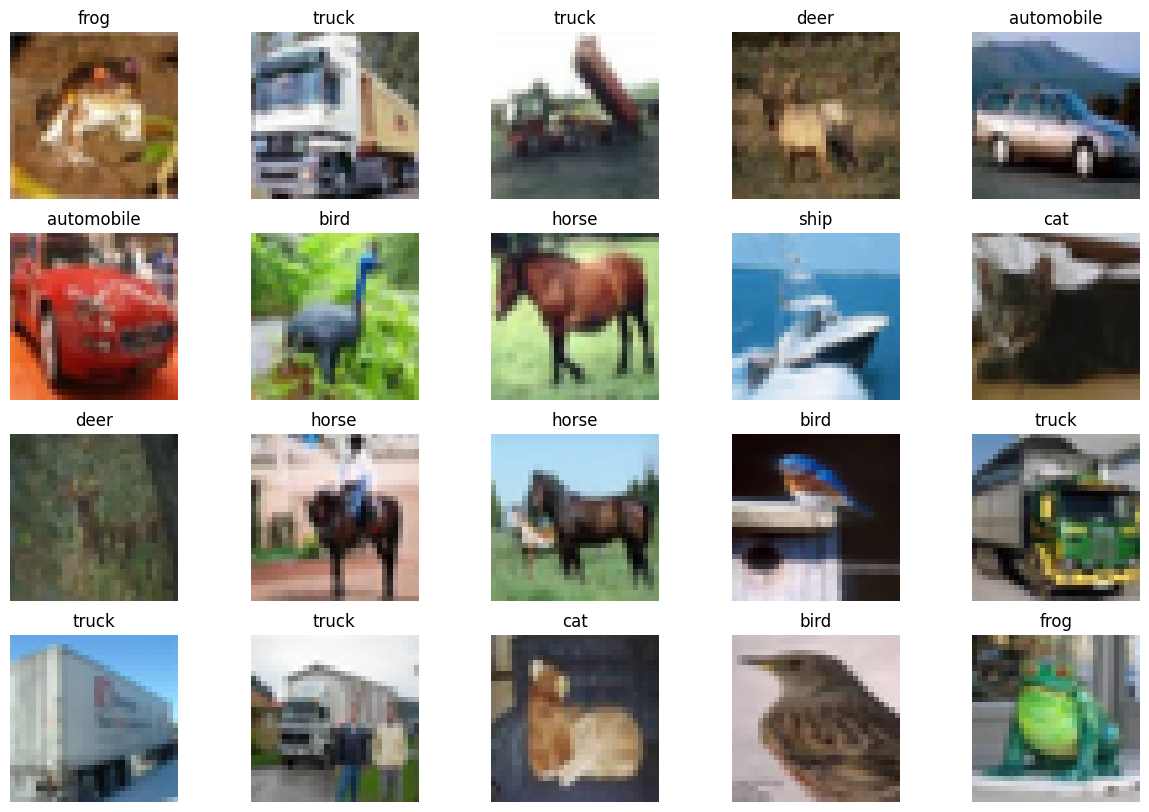

In [6]:
def show_images_grid(images, labels, num=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(class_names[labels[i][0]])
        ax.axis('off')
    plt.show()

show_images_grid(X_train, Y_train)

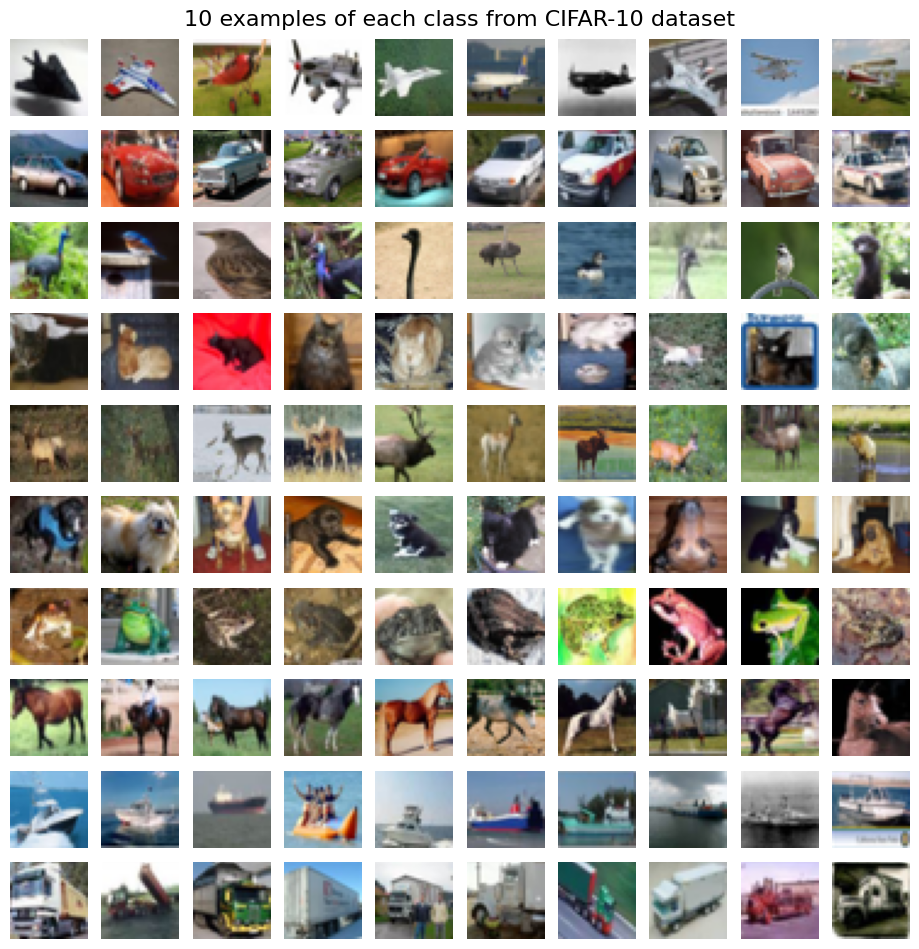

In [7]:
def show_images_from_each_class(images, labels, num_images=10):
    fig, axes = plt.subplots(10, num_images, figsize=(num_images, 10))
    #axes = axes.flatten()
    for class_index in range(10):
        class_images = images[labels.flatten() == class_index][:num_images]
        for j in range(num_images):
                axes[class_index, j].imshow(class_images[j])
                axes[class_index, j].axis('off')

        axes[class_index, 0].set_ylabel(class_names[class_index], fontsize=12, rotation=0, labelpad=40, ha='right', va='center')

    plt.suptitle("10 examples of each class from CIFAR-10 dataset", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.show()


show_images_from_each_class(X_train, Y_train)

In [8]:
pipeline = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),  # Changing smaller dimension to 128 and scaling second one
    transforms.GaussianBlur(5), #noise reduction filter with kernel size = 5
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = image[:3, :, :]  # Assuming the image has more than 3 channels, selecting the first 3 channels
        if self.transform:
            image = self.transform(image)
        return image, label

#
X_train = torch.tensor(X_train).permute(0, 3, 1, 2)  # Transforming from (batch, height, width, channels) to (batch, channels, height, width)
X_test = torch.tensor(X_test).permute(0, 3, 1, 2)
train_dataset = torch.utils.data.TensorDataset(X_train, torch.tensor(Y_train))
test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(Y_test))
train_loader = DataLoader(TransformedDataset(train_dataset, pipeline), batch_size=128, shuffle=True)
test_loader = DataLoader(TransformedDataset(test_dataset, pipeline), batch_size=128, shuffle=False)

In [10]:
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: torch.Size([50000, 3, 32, 32]) 
Y_train.shape: (50000, 1) 
X_test.shape: torch.Size([10000, 3, 32, 32]) 
Y_test.shape: (10000, 1)


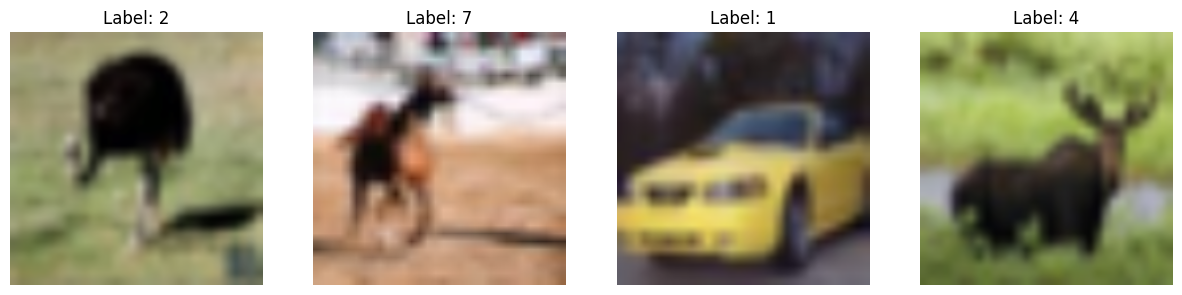

In [11]:
# plotting 4 first preprocessed images
for inputs, labels in train_loader:
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i in range(4):
        first_image = inputs[i]  # Tensor image
        first_label = labels[i]  # Label
        inp = first_image.numpy().transpose((1, 2, 0)) #converting to correct format for plotting
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean #denormalization for better plot visibility
        inp = np.clip(inp, 0, 1)
        axes[i].imshow(inp)
        axes[i].set_title(f'Label: {first_label.item()}')
        axes[i].axis('off')
    plt.show()
    break

# ResNet model

In [12]:
for image, label in train_loader:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([128, 3, 224, 224])
Image tensor:  tensor([[[[-0.6623, -0.6623, -0.6623,  ...,  0.6906,  0.6906,  0.6906],
          [-0.6623, -0.6623, -0.6623,  ...,  0.6906,  0.6906,  0.6906],
          [-0.6452, -0.6452, -0.6452,  ...,  0.6906,  0.6906,  0.6906],
          ...,
          [-0.9534, -0.9534, -0.9534,  ..., -0.3883, -0.3883, -0.3883],
          [-0.9534, -0.9534, -0.9534,  ..., -0.3883, -0.3883, -0.3883],
          [-0.9534, -0.9534, -0.9534,  ..., -0.3883, -0.3883, -0.3883]],

         [[-0.6877, -0.6877, -0.6877,  ...,  0.5028,  0.5028,  0.5028],
          [-0.6877, -0.6877, -0.6877,  ...,  0.5028,  0.5028,  0.5028],
          [-0.6702, -0.6702, -0.6702,  ...,  0.5028,  0.5028,  0.5028],
          ...,
          [-0.4076, -0.4076, -0.4076,  ...,  0.3277,  0.3277,  0.3277],
          [-0.4076, -0.4076, -0.4076,  ...,  0.3277,  0.3277,  0.3277],
          [-0.4076, -0.4076, -0.4076,  ...,  0.3277,  0.3277,  0.3277]],

         [[-1.4907, -1.4907, -1.4907,  ...

In [20]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet = resnet.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

In [23]:
num_epochs = 4
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, targets in progress_bar:
        images, targets = images.to(device), targets.to(device)

        if targets.dim() > 1:
            targets = targets.argmax(dim=1)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, targets)  #compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        progress_bar.set_postfix(loss=loss.item(), accuracy=f'{100*correct/total:.2f}%')

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch 1/4: 100%|██████████| 391/391 [06:59<00:00,  1.07s/it, accuracy=99.74%, loss=9.92e-7]


Epoch 1/4, Loss: 0.0096, Accuracy: 99.74%


Epoch 2/4: 100%|██████████| 391/391 [06:58<00:00,  1.07s/it, accuracy=100.00%, loss=1.04e-6]


Epoch 2/4, Loss: 0.0000, Accuracy: 100.00%


Epoch 3/4: 100%|██████████| 391/391 [06:58<00:00,  1.07s/it, accuracy=100.00%, loss=1.78e-6]


Epoch 3/4, Loss: 0.0000, Accuracy: 100.00%


Epoch 4/4: 100%|██████████| 391/391 [06:55<00:00,  1.06s/it, accuracy=100.00%, loss=1.66e-6]

Epoch 4/4, Loss: 0.0000, Accuracy: 100.00%


In [24]:
torch.save(resnet.state_dict(), "resnet_model.pth")